In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch import nn


In [2]:
n_samples = 1000

x, y = make_circles(
    n_samples=n_samples,
    factor=0.1,
    noise=0.3,
    random_state=42,
)

x[:5], y[:5]

(array([[-0.08405244,  0.25415948],
        [ 0.23323014,  0.24775516],
        [-0.31621319,  0.74268775],
        [-0.57365089, -0.21930602],
        [ 0.48803455, -0.87258708]]),
 array([1, 1, 1, 1, 0]))

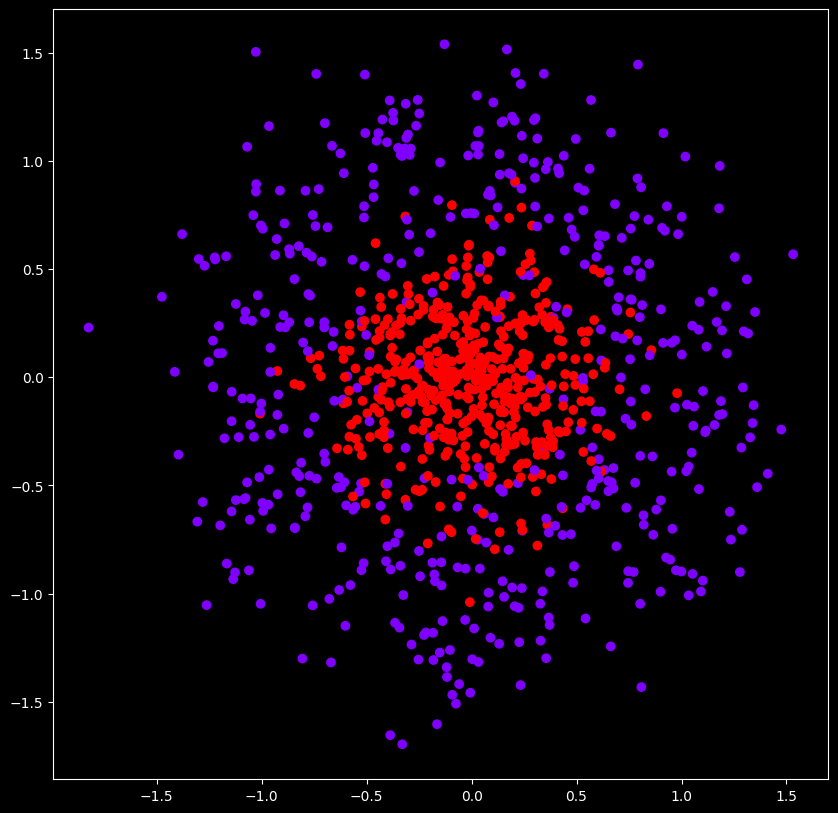

In [3]:
plt.figure(figsize=(10, 10))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="rainbow")
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [7]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.layer(tensor)


model = CircleModel().to(device)
model

CircleModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def accuracy_fn(y_pred: torch.Tensor, y_true: torch.Tensor):
    equal = torch.eq(y_pred, y_true).sum().item()
    return equal / len(y_true) * 100

In [9]:
torch.manual_seed(42)

epochs = 1000
x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    train_logits = model(x_train).squeeze()
    train_predictions = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_fn(train_logits, y_train)
    train_accuracy = accuracy_fn(train_predictions, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(test_predictions, y_test)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")


Epoch: 0, Train Loss: 0.7024181485176086, Train Accuracy: 50.0%, Test Loss: 0.6944692730903625, Test Accuracy: 50.0%
Epoch: 10, Train Loss: 0.6931820511817932, Train Accuracy: 54.0%, Test Loss: 0.6921035647392273, Test Accuracy: 44.0%
Epoch: 20, Train Loss: 0.6927595138549805, Train Accuracy: 43.375%, Test Loss: 0.6920992136001587, Test Accuracy: 62.0%
Epoch: 30, Train Loss: 0.692188560962677, Train Accuracy: 62.375%, Test Loss: 0.6919996738433838, Test Accuracy: 56.00000000000001%
Epoch: 40, Train Loss: 0.690990149974823, Train Accuracy: 57.875%, Test Loss: 0.6915386319160461, Test Accuracy: 56.99999999999999%
Epoch: 50, Train Loss: 0.6878677010536194, Train Accuracy: 63.24999999999999%, Test Loss: 0.6903133988380432, Test Accuracy: 59.0%
Epoch: 60, Train Loss: 0.6786094307899475, Train Accuracy: 71.75%, Test Loss: 0.6860013604164124, Test Accuracy: 66.0%
Epoch: 70, Train Loss: 0.6527958512306213, Train Accuracy: 74.875%, Test Loss: 0.6719527840614319, Test Accuracy: 66.5%
Epoch: 80, 

In [10]:
def plot_decision_boundry(model2plot: nn.Module, x_values: torch.Tensor, y_values: torch.Tensor):
    model2plot.to("cpu")
    x_values, y_values = x_values.to("cpu"), y_values.to("cpu")

    x_min, x_max = x_values[:, 0].min() - 0.1, x_values[:, 0].max() + 0.1,
    y_min, y_max = x_values[:, 1].min() - 0.1, x_values[:, 1].max() + 0.1,
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    x2pred_om = torch.from_numpy(np.column_stack([xx.ravel(), yy.ravel()])).float()

    model2plot.eval()
    with torch.inference_mode():
        y_logits = model2plot(x2pred_om).squeeze()

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) if len(torch.unique(y_values)) > 2 else torch.round(
        torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, s=40, cmap=plt.cm.RdYlBu, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

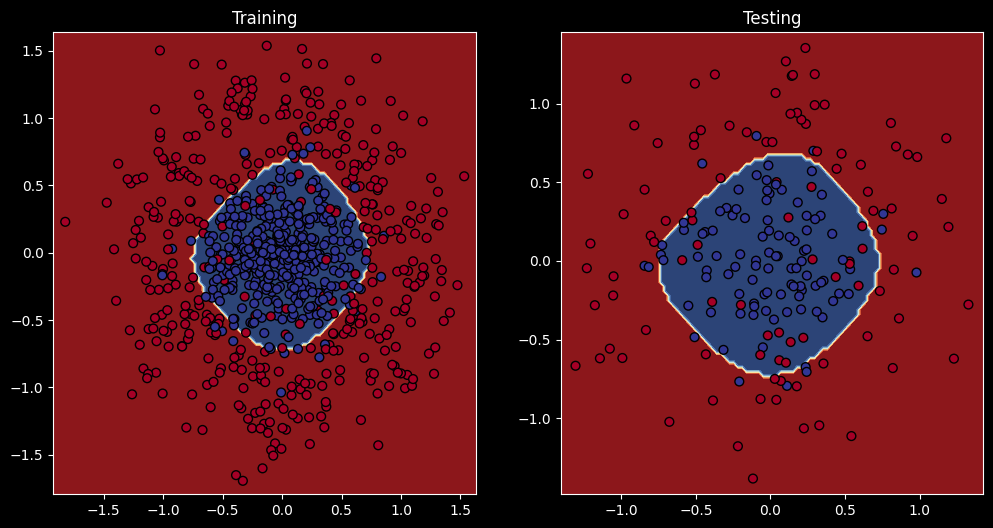

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundry(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundry(model, x_test, y_test)

In [17]:
from torchmetrics import Recall

x_test = x_test.to("cpu")
y_test = y_test.to("cpu")

logits = model(x_test).squeeze()
predictions = torch.round(torch.sigmoid(logits))

recall = Recall(task="binary", num_classes=2).to("cpu")
recall(predictions, y_test)

tensor(0.8600)